# Download Daymet

Daymet provides gridded meteorological data for North American at 1km spatial resolution with daily timestep from 1980 ~ present. [website](https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1328) and [user guide](https://daac.ornl.gov/DAYMET/guides/Daymet_V3_CFMosaics.html)

Available variables:

| Variable | Description (units) |
| ---- | ---- |
| tmax | Daily maximum 2-meter air temperature (°C) |
| tmin | Daily minimum 2-meter air temperature (°C) |
| prcp | Daily total precipitation (mm/day) |
| srad | Incident shortwave radiation flux density (W/m2) |
| vp   | Water vapor pressure (Pa) |
| swe  | Snow water equivalent (kg/m2) |
| dayl | Duration of the daylight period (seconds) |

Notes:
 - The Daymet calendar is based on a standard calendar year. <span style="color:blue;"> All Daymet years, including leap years, have 365 days. Keep this in mind during post-processing of model results!</span>  For leap years, the Daymet database includes leap day (February 29) and values for December 31 are discarded from leap years to maintain a 365-day year.
 
 - DayMet's incident shortwave radiation is the "daylit" radiation.  To get the daily average radiation, one must multiply by daylit fraction, given by dayl / 86400.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [2]:
import logging,yaml
import numpy as np
import rasterio
import fiona
import os
import datetime 

import watershed_workflow
import watershed_workflow.ui
import watershed_workflow.sources.manager_daymet
import watershed_workflow.daymet
import watershed_workflow.io

watershed_workflow.ui.setup_logging(1,None)

In [3]:
watershed_shapefile = '../../data/examples/CoalCreek/sources/shapefile/CoalCreek.shp'
config_fname = '../../data/examples/CoalCreek/processed/config.yaml'

In [4]:
# Load the dictionary from the file
with open(config_fname, 'r') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

In [5]:
# dates are in YYYY-MM-DD
# start and end of simulation -- one year of simulation that is in both the MODIS and DayMet dataset ranges
start_date = config['start_date']
end_date = config['end_date']
origin_date = config['origin_date']

## import watershed

In [6]:
crs, watershed = watershed_workflow.get_split_form_shapes(watershed_shapefile)
logging.info(f'crs: {crs}')

bounds = watershed.exterior().bounds
print(bounds)
print(bounds[2] - bounds[0], bounds[3] - bounds[1])

2023-07-20 16:42:44,530 - root - INFO: 
2023-07-20 16:42:44,531 - root - INFO: Loading shapes
2023-07-20 16:42:44,531 - root - INFO: ------------------------------
2023-07-20 16:42:44,532 - root - INFO: Loading file: '../../data/examples/CoalCreek/sources/shapefile/CoalCreek.shp'
2023-07-20 16:42:44,543 - root - INFO: ... found 1 shapes
2023-07-20 16:42:44,544 - root - INFO: Converting to shapely
2023-07-20 16:42:44,546 - root - INFO: crs: epsg:26913


(317251.2640131897, 4299711.408984916, 328473.7039815487, 4307062.45088187)
11222.439968359016 7351.041896954179


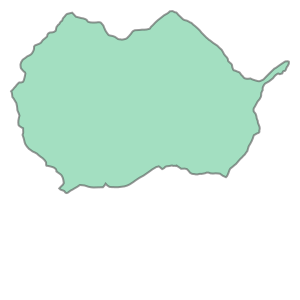

In [7]:
watershed.exterior()

## Download

returned raw data has `dim(nband, ncol, nrow)`

In [8]:
# setting vars = None to download all available variables
source = watershed_workflow.sources.manager_daymet.FileManagerDaymet()
data = source.get_data(bounds, crs, start = start_date, end = end_date, buffer=0.02)

2023-07-20 16:42:44,637 - root - INFO: Collecting DayMet file to tile bounds: [-107.1272, 38.8072, -106.956, 38.9157]
2023-07-20 16:42:44,638 - root - INFO:   Using existing: /Users/shuai/github/watershed-workflow/data_library/meteorology/daymet/daymet_tmin_2015_38.9157x-107.1272_38.8072x-106.9560.nc
2023-07-20 16:42:44,638 - root - INFO: Collecting DayMet file to tile bounds: [-107.1272, 38.8072, -106.956, 38.9157]
2023-07-20 16:42:44,640 - root - INFO:   Downloading: http://thredds.daac.ornl.gov/thredds/ncss/grid/ornldaac/2129/daymet_v4_daily_na_tmin_2016.nc
2023-07-20 16:42:44,640 - root - INFO:       to file: /Users/shuai/github/watershed-workflow/data_library/meteorology/daymet/daymet_tmin_2016_38.9157x-107.1272_38.8072x-106.9560.nc
2023-07-20 16:42:55,559 - root - INFO: Collecting DayMet file to tile bounds: [-107.1272, 38.8072, -106.956, 38.9157]
2023-07-20 16:42:55,565 - root - INFO:   Using existing: /Users/shuai/github/watershed-workflow/data_library/meteorology/daymet/daymet

## Reproject Daymet CRS

Reproject daymet CRS to the same as the watershed. This is necessary if watershed meshes are using watershed CRS.

In [9]:
data_new = watershed_workflow.warp.state(data, dst_crs=crs)

## plot Daymet

/Users/shuai/mambaforge/envs/watershed_workflow-2023-04-03/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
2023-07-20 16:44:09,995 - root - INFO: BOUNDS: (-591250.0, -367000.0, -576250.0, -355000.0)
2023-07-20 16:44:10,002 - root - INFO: BOUNDS: (314692.7009557779, 4296566.393670194, 331256.0668364615, 4310206.812630757)


Text(0.5, 1.0, 'Reprojected Daymet')

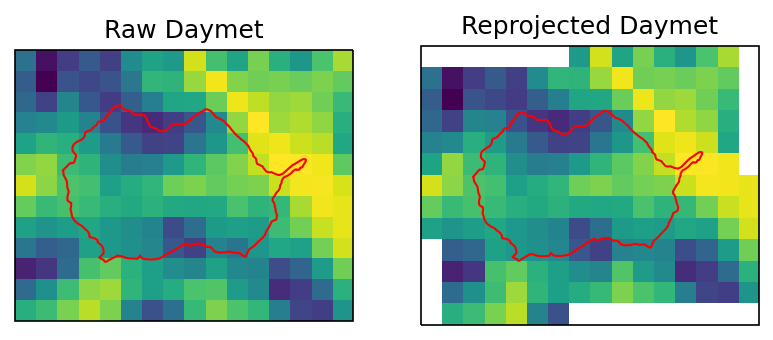

In [10]:
ivar = 'tmax'
islice = 100
daymet_crs = watershed_workflow.crs.daymet_crs()

fig = plt.figure()
ax1 = watershed_workflow.plot.get_ax(daymet_crs, fig, 1, 2, 1)
ax2 = watershed_workflow.plot.get_ax(crs, fig, 1, 2, 2)

watershed_ext_daymet = watershed_workflow.warp.shply(watershed.exterior(),
                                                     crs, daymet_crs)
watershed_workflow.plot.raster(data[ivar].profile, data[ivar].data[islice,:,:], ax1)
watershed_workflow.plot.shply(watershed_ext_daymet, daymet_crs, ax=ax1, color='r')

watershed_workflow.plot.raster(data_new[ivar].profile, data_new[ivar].data[islice,:,:], ax2)
watershed_workflow.plot.hucs(watershed, crs, ax=ax2, color='r')

ax1.set_title("Raw Daymet")
ax2.set_title("Reprojected Daymet")



# save daymet

## Write data to HDF5

This will write daymet in a format that ATS can read. E.g., this will calculate mean air temperature, convert units, partition precipitation into rain and snow based on mean temp, and so on.

- dout has dims of `(ntime, nrow, ncol)` or `(ntime, ny, nx)`

In [11]:
assert(len(data_new.collections) == 1)
met_data = data_new.collections[0]

In [12]:
met_data_ats = watershed_workflow.daymet.daymet_to_daily_averages(met_data)


config['daymet_filename'] = os.path.join('..', '..', 'data', 'examples','CoalCreek', 'processed','watershed_daymet_raw.h5')
attrs = watershed_workflow.daymet.getAttributes(bounds, start_date, end_date)
attrs['name']="Daymet forcing reformatted for ats modeling"

watershed_workflow.io.write_dataset_to_hdf5(
    filename = config['daymet_filename'],
    dataset= met_data_ats.collections[0],
    attributes= attrs,
    time0 = origin_date
)
    

2023-07-20 16:44:10,164 - root - INFO: Converting to ATS met input
2023-07-20 16:44:10,168 - root - INFO: Writing HDF5 file: ../../data/examples/CoalCreek/processed/watershed_daymet_raw.h5


## Write typical Daymet

This will average days, smooths the forcing and generate a "typical year" data, then looped 10 years. The dataset will be used during cyclic spinup.

In [13]:
config['daymet_typical_filename'] = os.path.join('..', '..', 'data', 'examples','CoalCreek', 'processed','watershed_daymet_typical.h5')

met_data_typical = watershed_workflow.datasets.State()
ntypical_years = 10
# here we make up some new times. 
# It does not really matter what timeframe you choose as long as the nunmber of days are consistent.
new_times = np.array([datetime.date(1980,10,1) + datetime.timedelta(days=i) for i in range(365*ntypical_years)])

for (ds_key, ds_val) in met_data_ats.items():
    # average and smooth forcing data. Hint: make filter=False if no smoothing is needed.
    smooth_dat = watershed_workflow.utils.compute_average_year(ds_val.data, output_nyears=ntypical_years, filter=True)
    met_data_typical[ds_key] = watershed_workflow.datasets.Dataset(ds_val.profile, new_times, smooth_dat)

attrs = watershed_workflow.daymet.getAttributes(bounds, new_times[0], new_times[-1])
attrs['name']=f"{ntypical_years}-yrs typical Daymet forcing generated using data from {start_date} to {end_date}"

watershed_workflow.io.write_dataset_to_hdf5(config['daymet_typical_filename'], met_data_typical.collections[0], 
                                            attributes=attrs, time0=origin_date)

2023-07-20 16:44:10,762 - root - INFO: Writing HDF5 file: ../../data/examples/CoalCreek/processed/watershed_daymet_typical.h5


2023-07-20 16:44:12,976 - root - INFO: BOUNDS: (314692.7009557779, 4296566.393670194, 331256.0668364615, 4310206.812630757)
2023-07-20 16:44:12,978 - root - INFO: BOUNDS: (314692.7009557779, 4296566.393670194, 331256.0668364615, 4310206.812630757)


Text(0.5, 1.0, 'Typical Daymet')

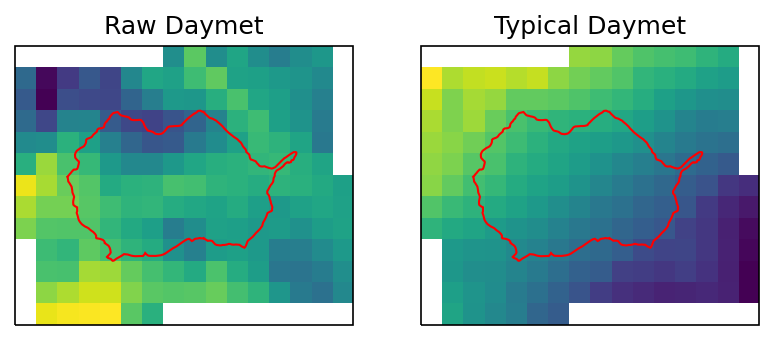

In [14]:
# after smoothing, the forcing can look quite different!
ivar = 'air temperature [K]'
islice = 100
# daymet_crs = watershed_workflow.crs.daymet_crs()
profile = met_data_ats.collections[0].profile

fig = plt.figure()
ax1 = watershed_workflow.plot.get_ax(crs, fig, 1, 2, 1)
ax2 = watershed_workflow.plot.get_ax(crs, fig, 1, 2, 2)

watershed_workflow.plot.raster(profile, met_data_ats.collections[0].data[ivar][islice,:,:], ax1)
watershed_workflow.plot.hucs(watershed, crs, ax=ax1, color='r')

watershed_workflow.plot.raster(profile, met_data_typical.collections[0].data[ivar][islice,:,:], ax2)
watershed_workflow.plot.hucs(watershed, crs, ax=ax2, color='r')

ax1.set_title("Raw Daymet")
ax2.set_title("Typical Daymet")



Get mean precipitation for spinup

In [15]:
# calculate the basin-averaged, annual-averaged precip rate
precip_total = met_data_typical.collections[0].data['precipitation rain [m s^-1]'] + met_data_typical.collections[0].data['precipitation snow [m SWE s^-1]']
mean_precip = precip_total.mean()
config['mean_precip [m s^-1]'] = float(mean_precip)
logging.info(f'Mean annual precip rate [m s^-1] = {mean_precip}')

2023-07-20 16:44:13,081 - root - INFO: Mean annual precip rate [m s^-1] = 2.215898101534863e-08


In [16]:
with open(config_fname, 'w') as file:
    yaml.dump(config, file)